<a href="https://colab.research.google.com/github/YoofKhaneja/Analyzing-Risk-of-CHD-with-Discriminative-NN/blob/master/Pretrained_Model_New_Prompt_Inference_%2B_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing requirements

%%capture
!pip install huggingface_hub
!pip install transformers==4.31.0
!pip install accelerate
!pip install bitsandbytes
!pip install ninja
!pip install -U flash-attn --no-build-isolation
!pip install sentencepiece
!pip install flash-attn
!pip install langchain langchain_community
!pip install xformers

In [ ]:
# Mounting the drive

%%capture
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Check before each run
# Set batch number (1-20) to test

batch = 1

In [ ]:
# Libraries and paths

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from langchain import HuggingFacePipeline, PromptTemplate, LLMChain

import warnings
warnings.filterwarnings('ignore')

import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_path = '/content/drive/MyDrive/Models'
input_path = '/content/drive/MyDrive/Output/Note Files'
output_path = '/content/drive/MyDrive/Output'

In [ ]:
# Data read-in

labelled_notes = pd.read_parquet(input_path + f'/labelled_notes_{batch}.parquet')
labelled_notes.sample(5)

,summary,label
115340,START\n\nhistory of present illness:\nthis pat...,0
73320,START\n\nhistory of present illness:\nthe pt i...,0
160,START\n\nhistory of present illness:\npatient ...,1
64520,START\n\nhistory of present illness:\nmr. ___ ...,0
94500,START\n\nhistory of present illness:\npt is a ...,0


In [ ]:
# Loading the model

bnb_config = BitsAndBytesConfig(load_in_4bit = True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16,)

tokenizer = AutoTokenizer.from_pretrained(model_path + '/Ascleipus-7B')
model = AutoModelForCausalLM.from_pretrained(model_path + '/Ascleipus-7B', quantization_config=bnb_config).bfloat16().cuda()

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Setting up the pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    max_length=4096,
    do_sample=True,
    temperature=0.001,
    top_p=0.5,
    top_k=5
)

llm = HuggingFacePipeline(pipeline = pipeline)

In [ ]:
# Defining the template

template = """
              ```{text}```
              You are a smart medical professional. Break down the discharge note delimited by triple backquotes and answer the following question:
              Question 1: is there a mention of heart failure in the discharge note? Return "Yes" or "No".
              Answer 1:
              Use only the input text to answer the question, and keep your response as short as possible/
              ***
           """

prompt = PromptTemplate(template=template, input_variables=["text"])

llm_chain = LLMChain(prompt=prompt, llm=llm)

In [ ]:
# Generating outputs

final_output = []

for n in tqdm.tqdm(labelled_notes['summary']):
    o = llm_chain.invoke(n)['text']
    o = o[o.find('***')+3:]
    o = str.strip(o)
    final_output.append(o)

100%|██████████| 6629/6629 [3:01:06<00:00,  1.64s/it]


In [ ]:
# Formatting outputs

labelled_notes['llm_out'] = final_output

split_output = [i.split(' ') for i in final_output]
first_words = [i[0].split(',')[0].strip().lower() for i in split_output]
pred_labels = [1 if i == 'yes' else 0 for i in first_words]

labelled_notes['pred_label'] = pred_labels

In [ ]:
# Confusion matrix

cm = confusion_matrix(labelled_notes['label'], labelled_notes['pred_label'])
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(cm_df)

          Predicted 0  Predicted 1
Actual 0         6105            4
Actual 1          308          212


In [ ]:
# Accuracy, F1, AUROC

accuracy = accuracy_score(labelled_notes['label'], labelled_notes['pred_label'])
f1 = f1_score(labelled_notes['label'], labelled_notes['pred_label'])
auroc = roc_auc_score(labelled_notes['label'], labelled_notes['pred_label'])
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("AUROC:", auroc)

Accuracy: 0.9529340775380902
F1-score: 0.5760869565217391
AUROC: 0.70351876802196


In [ ]:
# Classification report

report = classification_report(labelled_notes['label'], labelled_notes['pred_label'])
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      6109
           1       0.98      0.41      0.58       520

    accuracy                           0.95      6629
   macro avg       0.97      0.70      0.78      6629
weighted avg       0.95      0.95      0.94      6629



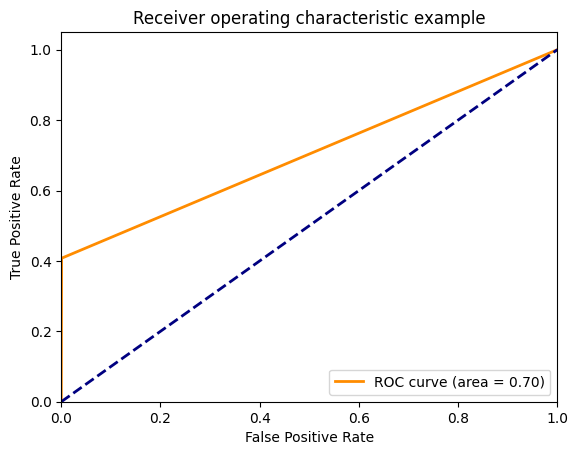

In [ ]:
# ROC curve

predictions_proba = [1 if x == 1 else 0 for x in labelled_notes['label']]
fpr, tpr, thresholds = roc_curve(labelled_notes['label'], labelled_notes['pred_label'])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Exporting the results

labelled_notes.to_parquet(output_path + f'/llm_output_{batch}.parquet')